# Neural Networks - Part-2 L2 Regularization



## L2 Regularization

The standard way to avoid overfitting is called **L2 regularization**. 
It consists of appropriately modifying cost function in model. 

**`compute_cost()`**:
$$J = -\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small  y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} $$

**`compute_cost_with_regularization()`**:
$$J_{regularized} = \small \underbrace{-\frac{1}{m} \sum\limits_{i = 1}^{m} \large{(}\small y^{(i)}\log\left(a^{[L](i)}\right) + (1-y^{(i)})\log\left(1- a^{[L](i)}\right) \large{)} }_\text{cross-entropy cost} + \underbrace{\frac{1}{m} \frac{\lambda}{2} \sum\limits_l\sum\limits_k\sum\limits_j W_{k,j}^{[l]2} }_\text{L2 regularization cost}$$

In same way we also Modify Backpropagation function from **backward_propagation()** to **backward_propagation_with_regularization()** and use Regularization term's gradient ($\frac{d}{dW} ( \frac{1}{2}\frac{\lambda}{m}  W^2) = \frac{\lambda}{m} W$).

- The value of $\lambda$ is a hyperparameter that you can tune using a dev set.
- L2 regularization makes your decision boundary smoother. If $\lambda$ is too large, it is also possible to "oversmooth", resulting in a model with high bias.

**What L2-regularization actually do**:

L2-regularization relies on the assumption that a model with small weights is simpler than a model with large weights. Thus, by penalizing the square values of the weights in the cost function you drive all the weights to smaller values. It becomes too costly for the cost to have large weights! This leads to a smoother model in which the output changes more slowly as the input changes. 

**The implications of L2-regularization on Model**:
- The cost computation:
    - A regularization term is added to the cost
- The backpropagation function:
    - There are extra terms in the gradients with respect to weight matrices
- Weights end up smaller ("weight decay"): 
    - Weights are pushed to smaller values.

## Building L2 Regularized Model

A 3 Layer Neural Network

Model Structure is
**LINEAR -> RELU ->| LINEAR -> RELU ->| LINEAR -> SIGMOID**

In [2]:
import numpy as np
import matplotlib.pyplot as plt

###### Helper Functions

In [3]:
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s
#################################################
def relu(x):
    s = np.maximum(0,x)
    return s
#################################################
def initialize_parameters(layer_dims):
    np.random.seed(3)
    parameters = {}
    L = len(layer_dims) # number of layers in the network
    for l in range(1, L):
        parameters['W' + str(l)] = np.random.randn(layer_dims[l], layer_dims[l-1]) / np.sqrt(layer_dims[l-1])
        parameters['b' + str(l)] = np.zeros((layer_dims[l], 1))
           
    return parameters
#################################################
def forward_propagation(X, parameters):
    # retrieve parameters
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    W3 = parameters["W3"]
    b3 = parameters["b3"]
    
    # LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID
    Z1 = np.dot(W1, X) + b1
    A1 = relu(Z1)
    Z2 = np.dot(W2, A1) + b2
    A2 = relu(Z2)
    Z3 = np.dot(W3, A2) + b3
    A3 = sigmoid(Z3)
    
    cache = (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3)
    
    return A3, cache
#################################################
def backward_propagation(X, Y, cache):
    
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache
    
    dZ3 = A3 - Y
    dW3 = 1./m * np.dot(dZ3, A2.T)
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))
    dW2 = 1./m * np.dot(dZ2, A1.T)
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T)
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,
                 "dA2": dA2, "dZ2": dZ2, "dW2": dW2, "db2": db2,
                 "dA1": dA1, "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients
#################################################
def update_parameters(parameters, grads, learning_rate):
    n = len(parameters) // 2 # number of layers in the neural networks

    # Update rule for each parameter
    for k in range(n):
        parameters["W" + str(k+1)] = parameters["W" + str(k+1)] - learning_rate * grads["dW" + str(k+1)]
        parameters["b" + str(k+1)] = parameters["b" + str(k+1)] - learning_rate * grads["db" + str(k+1)]
        
    return parameters

#################################################
def compute_cost(a3, Y):
    m = Y.shape[1]
    logprobs = np.multiply(-np.log(a3),Y) + np.multiply(-np.log(1 - a3), 1 - Y)
    cost = 1./m * np.nansum(logprobs)
    return cost
#################################################
def predict(parameters, X):
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = forward_propagation(X, parameters)
    predictions = (a3>0.5)
    return predictions

#################################################
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y.ravel(), cmap=plt.cm.Spectral)
    plt.show()
    

##### Compute Cost with Regularization

In [4]:
def compute_cost_with_regularization(A3, Y, parameters, lambd): 
    m = Y.shape[1]
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    W3 = parameters["W3"]
    cross_entropy_cost = compute_cost(A3, Y) # This gives you the cross-entropy part of the cost
    L2_regularization_cost = lambd / (2 * m) * (np.sum(np.square(W1)) 
                                                + np.sum(np.square(W2)) 
                                                + np.sum(np.square(W3)))
    cost = cross_entropy_cost + L2_regularization_cost
    return cost

##### Backward Propagation with Regularization

In [5]:
def backward_propagation_with_regularization(X, Y, cache, lambd):
    m = X.shape[1]
    (Z1, A1, W1, b1, Z2, A2, W2, b2, Z3, A3, W3, b3) = cache    
    dZ3 = A3 - Y

    dW3 = 1./m * np.dot(dZ3, A2.T) + lambd / m * W3
    db3 = 1./m * np.sum(dZ3, axis=1, keepdims = True)
    
    dA2 = np.dot(W3.T, dZ3)
    dZ2 = np.multiply(dA2, np.int64(A2 > 0))

    dW2 = 1./m * np.dot(dZ2, A1.T) + lambd / m * W2
    db2 = 1./m * np.sum(dZ2, axis=1, keepdims = True)
    
    dA1 = np.dot(W2.T, dZ2)
    dZ1 = np.multiply(dA1, np.int64(A1 > 0))
    dW1 = 1./m * np.dot(dZ1, X.T) + lambd / m * W1
    db1 = 1./m * np.sum(dZ1, axis=1, keepdims = True)
    
    gradients = {"dZ3": dZ3, "dW3": dW3, "db3": db3,"dA2": dA2,
                 "dZ2": dZ2, "dW2": dW2, "db2": db2, "dA1": dA1, 
                 "dZ1": dZ1, "dW1": dW1, "db1": db1}
    
    return gradients

###### Model

Model with L2 regularization  will use: 
- `compute_cost_with_regularization` instead of `compute_cost`
- `backward_propagation_with_regularization` instead of `backward_propagation`

In [6]:
def model(X, Y, learning_rate = 0.3, num_iterations = 30000, print_cost = True, lambd = 0):
    
    grads = {}

    costs = []                            # to keep track of the cost
    m = X.shape[1]                        # number of examples
    layers_dims = [X.shape[0], 20, 3, 1]
    
    # Initialize parameters dictionary.
    parameters = initialize_parameters(layers_dims)

    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SIGMOID.
        a3, cache = forward_propagation(X, parameters)
               
        # Cost function
        cost = compute_cost_with_regularization(a3, Y, parameters, lambd)
        
        # Back propagation
        grads = backward_propagation_with_regularization(X, Y, cache, lambd)
        
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # Print the loss every 10000 iterations
        if print_cost and i % 10000 == 0:
            print("Cost after iteration {}: {}".format(i, cost))
        if print_cost and i % 1000 == 0:
            costs.append(cost)
    
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x1,000)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

## Problem Statement
You have just been hired as an AI expert by the French Football Corporation. They would like you to recommend positions where France's goal keeper should kick the ball so that the French team's players can then hit it with their head. 

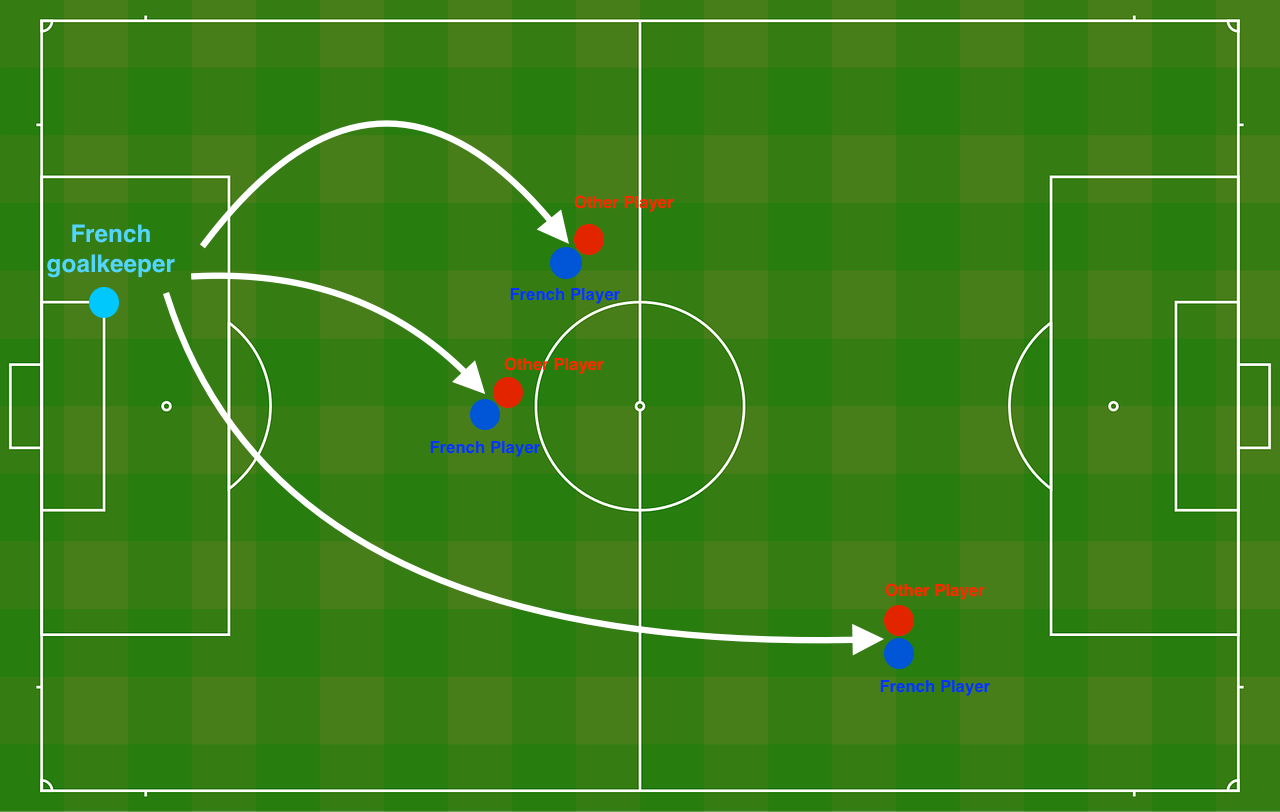

The goal keeper kicks the ball in the air, the players of each team are fighting to hit the ball with their head. 
They give you the following 2D dataset from France's past 10 games.

Each dot corresponds to a position on the football field where a football player has hit the ball with his/her head after the French goal keeper has shot the ball from the left side of the football field.
- If the dot is blue, it means the French player managed to hit the ball with his/her head
- If the dot is red, it means the other team's player hit the ball with their head

**Your goal**: Use a deep learning model to find the positions on the field where the goalkeeper should kick the ball.

## Load Dataset

In [7]:
testData = np.loadtxt("../input/footballDS/football_test.csv", delimiter=',',unpack=True)
test_X,test_Y=testData[0:2,:],testData[2:3,:]
trainData = np.loadtxt("../input/footballDS/football_train.csv", delimiter=',',unpack=True)
train_X,train_Y=trainData[0:2,:],trainData[2:3,:]


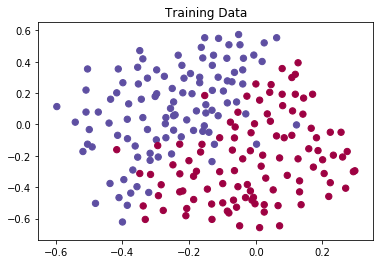

In [8]:
plt.scatter(train_X[0,:], train_X[1, :], c=train_Y.ravel(), s=40, cmap=plt.cm.Spectral);
plt.title("Training Data")
plt.show()

**Analysis of the dataset**: This dataset is a little noisy, but it looks like a diagonal line separating the upper left half (blue) from the lower right half (red) would work well. 

## Training of the model with L2 regularization

Cost after iteration 0: 0.6974484493131264
Cost after iteration 10000: 0.26849188732822393
Cost after iteration 20000: 0.2680916337127301


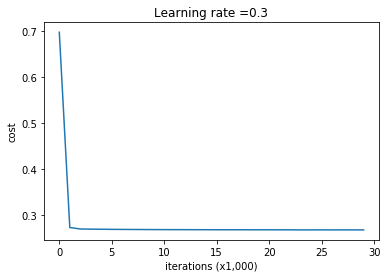

In [10]:
parameters = model(train_X, train_Y, lambd = 0.7)

## Plotting Decision Boundry

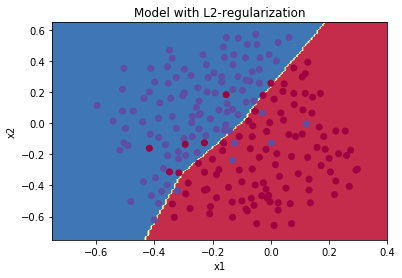

In [11]:
plt.title("Model with L2-regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict(parameters, x.T), train_X, train_Y)

## Prediction Accuracy

In [12]:
print ("On the training set:")
Y_prediction_train = predict(parameters,train_X)
print("train accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_train - train_Y)) * 100))
print ("On the test set:")
Y_prediction_test = predict(parameters,test_X )
print("test accuracy: {} %".format(100 - np.mean(np.abs(Y_prediction_test - test_Y)) * 100))

On the training set:
train accuracy: 93.8388625592417 %
On the test set:
test accuracy: 93.0 %


Test set accuracy increased to 93%. 
In **baseline model** the train accuracy was 94.8% while the test accuracy was 91.5%.